data: [Stock Market Dataset](https://www.kaggle.com/datasets/jacksoncrow/stock-market-dataset/data) <br>
시계열 데이터, ADF Test, KPSS Test, ACF, PACF, AR, MA, ARMA, RAIMA, 잔차 ACF/PACF

In [1]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from arch import arch_model
import statsmodels.api as sm
import seaborn as sns

In [2]:
aapl_path = '/hdd/data/adp_data/stocks/AAPL.csv'
aapl_df = pd.read_csv(aapl_path, parse_dates = ['Date'], index_col = 'Date')
aapl_df = aapl_df[-200:]
display(aapl_df.head())

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-06-18,196.050003,200.289993,195.210007,198.449997,196.640396,26551000
2019-06-19,199.679993,199.880005,197.309998,197.869995,196.065689,21124200
2019-06-20,200.369995,200.610001,198.029999,199.460007,197.641190,21514000
2019-06-21,198.800003,200.850006,198.149994,198.779999,196.967377,47800600
2019-06-24,198.539993,200.160004,198.169998,198.580002,196.769211,18220400


귀무가설: 이 시계열은 비정상(non-stationary)이다.<br>
대립가설: 이 시계열은 정상(stationary)이다.

In [3]:
adj_close = aapl_df['Adj Close'].dropna()

adf_result = adfuller(adj_close)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
for key, value in adf_result[4].items():
    print(f'Critical Value ({key}): {value}')

ADF Statistic: -1.3767365683420354
p-value: 0.5933767001673952
Critical Value (1%): -3.4652439354133255
Critical Value (5%): -2.8768752281673717
Critical Value (10%): -2.574944653739612


귀무가설: 이 시계열은 정상(stationary)이다.<br>
대립가설: 이 시계열은 비정상(non-stationary)이다.

In [4]:
kpss_stat, p_value, lags, crit = kpss(adj_close, regression ='c', nlags = 'auto')
print('KPSS Statistic:', kpss_stat)
print('p-value:', p_value)
for key, value in crit.items():
    print(f'Critical Value ({key}): {value}')

KPSS Statistic: 1.6649995884189448
p-value: 0.01
Critical Value (10%): 0.347
Critical Value (5%): 0.463
Critical Value (2.5%): 0.574
Critical Value (1%): 0.739


/tmp/ipykernel_2369378/3957763266.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, p_value, lags, crit = kpss(adj_close, regression ='c', nlags = 'auto')


In [5]:
adj_close_diff = adj_close.diff().dropna()

adf_result_diff = adfuller(adj_close_diff)

print('ADF Statistic (1st diff):', adf_result_diff[0])
print('p-value:', adf_result_diff[1])
for key, value in adf_result_diff[4].items():
    print(f'Critical Value ({key}): {value}')

ADF Statistic (1st diff): -3.945733496804668
p-value: 0.0017228998791995987
Critical Value (1%): -3.4652439354133255
Critical Value (5%): -2.8768752281673717
Critical Value (10%): -2.574944653739612


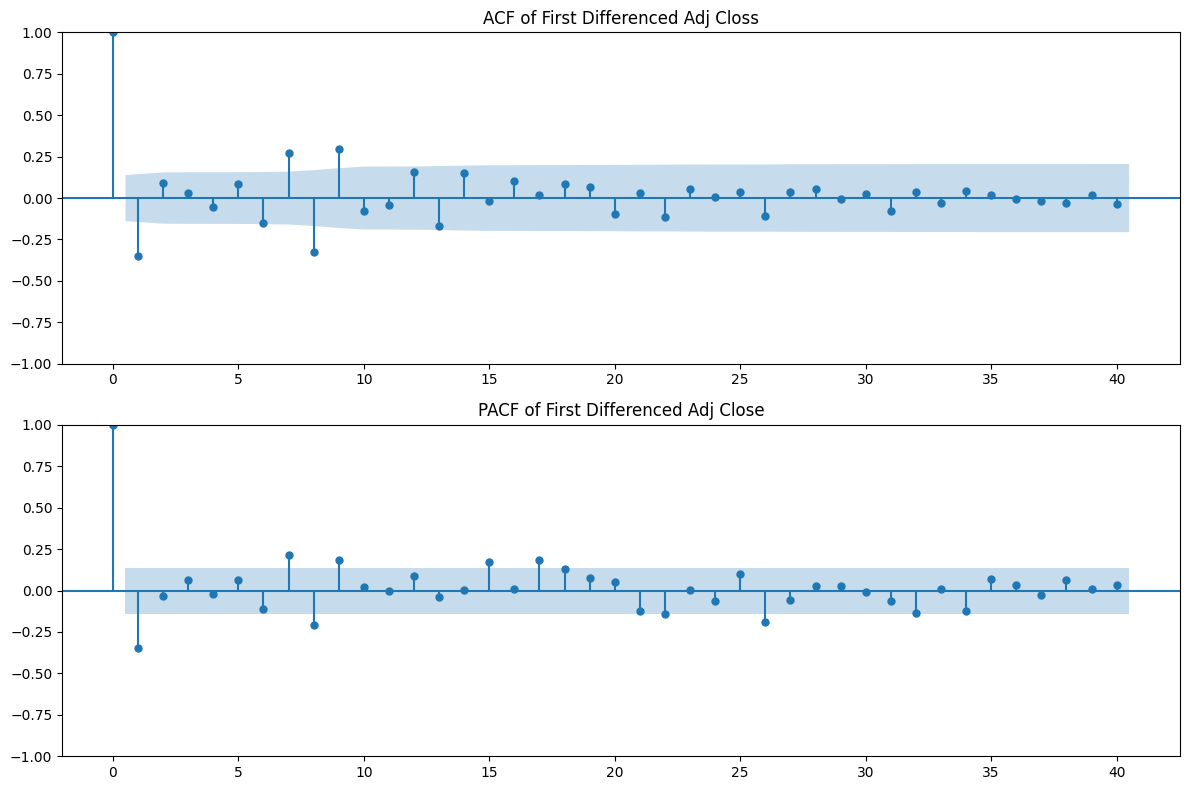

In [6]:
fig, ax = plt.subplots(2, 1, figsize = (12, 8))

plot_acf(adj_close_diff, ax = ax[0], lags = 40)
ax[0].set_title('ACF of First Differenced Adj Closs')

plot_pacf(adj_close_diff, ax = ax[1], lags = 40, method = 'ywm')
ax[1].set_title('PACF of First Differenced Adj Close')

plt.tight_layout()
plt.show()

/home/ubuntu/work_space/adp_hands_on/.adp_hands_on/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                            AutoReg Model Results                             
Dep. Variable:              Adj Close   No. Observations:                  199
Model:                     AutoReg(2)   Log Likelihood                -647.194
Method:               Conditional MLE   S.D. of innovations              6.464
Date:                Tue, 06 May 2025   AIC                           1302.387
Time:                        15:46:29   BIC                           1315.520
Sample:                             2   HQIC                          1307.703
                                  199                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.3399      0.462      0.736      0.462      -0.565       1.245
Adj Close.L1    -0.3676      0.072     -5.103      0.000      -0.509      -0.226
Adj Close.L2    -0.0392      0.072     -0.54

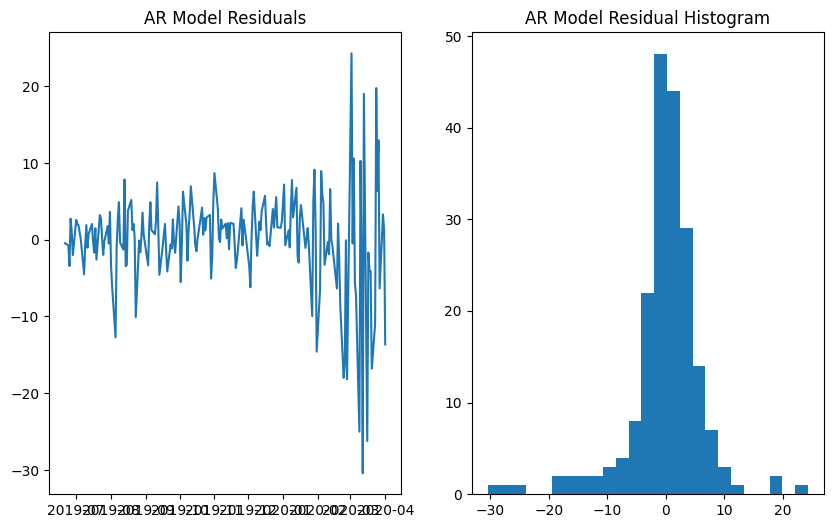

      lb_stat  lb_pvalue
10  24.659535    0.00603


In [7]:
ar_model = AutoReg(adj_close_diff, lags = 2)
ar_fitted_model = ar_model.fit()

print(ar_fitted_model.summary())

ar_residuals = ar_fitted_model.resid
plt.figure(figsize = (10, 6))
plt.subplot(121)
plt.plot(ar_residuals)
plt.title('AR Model Residuals')
plt.subplot(122)
plt.hist(ar_residuals, bins = 25)
plt.title('AR Model Residual Histogram')
plt.show()

ljung_box_ar = acorr_ljungbox(ar_residuals, lags = [10], return_df = True)
print(ljung_box_ar)

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  199
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -652.626
Date:                Tue, 06 May 2025   AIC                           1313.251
Time:                        15:46:29   BIC                           1326.424
Sample:                             0   HQIC                          1318.583
                                - 199                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2403      0.440      0.546      0.585      -0.623       1.104
ma.L1         -0.3651      0.047     -7.748      0.000      -0.457      -0.273
ma.L2          0.1216      0.040      3.016      0.0

/home/ubuntu/work_space/adp_hands_on/.adp_hands_on/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ubuntu/work_space/adp_hands_on/.adp_hands_on/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ubuntu/work_space/adp_hands_on/.adp_hands_on/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


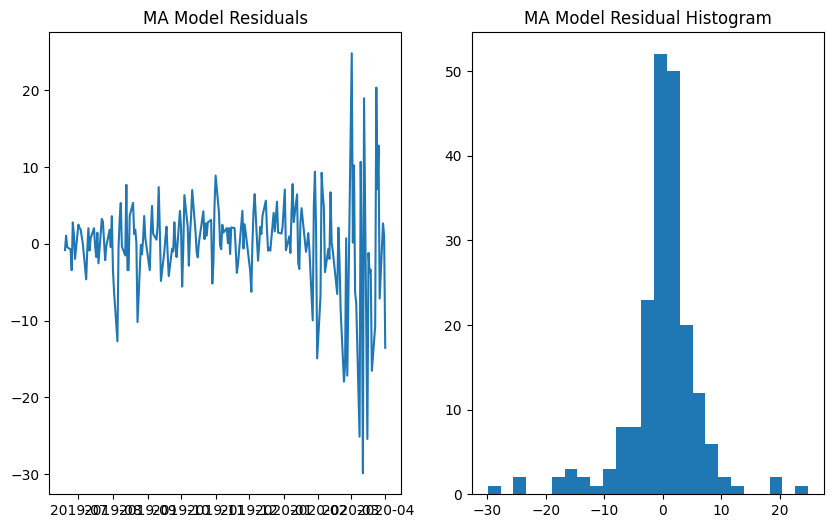

      lb_stat  lb_pvalue
10  23.869687   0.007954


In [8]:
ma_model = ARIMA(adj_close_diff, order = (0, 0, 2))
ma_fitted_model = ma_model.fit()

print(ma_fitted_model.summary())

ma_residuals = ma_fitted_model.resid
plt.figure(figsize = (10, 6))
plt.subplot(121)
plt.plot(ma_residuals)
plt.title('MA Model Residuals')
plt.subplot(122)
plt.hist(ma_residuals, bins = 25)
plt.title('MA Model Residual Histogram')
plt.show()

ljung_box_ma = acorr_ljungbox(ma_residuals, lags = [10], return_df = True)
print(ljung_box_ma)

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  199
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -644.987
Date:                Tue, 06 May 2025   AIC                           1301.973
Time:                        15:46:30   BIC                           1321.733
Sample:                             0   HQIC                          1309.971
                                - 199                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2419      0.429      0.564      0.573      -0.599       1.083
ar.L1         -1.4528      0.099    -14.743      0.000      -1.646      -1.260
ar.L2         -0.5650      0.091     -6.199      0.0

/home/ubuntu/work_space/adp_hands_on/.adp_hands_on/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ubuntu/work_space/adp_hands_on/.adp_hands_on/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ubuntu/work_space/adp_hands_on/.adp_hands_on/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


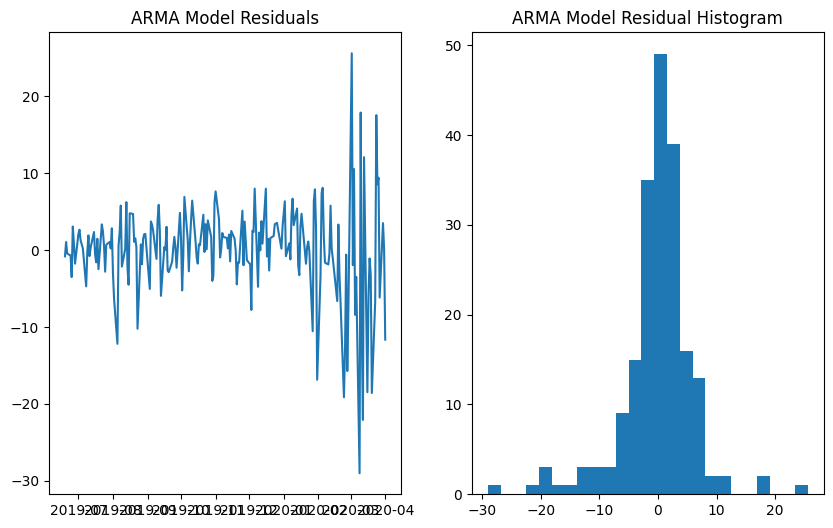

      lb_stat  lb_pvalue
10  10.511888   0.396787


In [9]:
arma_model = ARIMA(adj_close_diff, order = (2, 0, 2))
arma_fitted_model = arma_model.fit()

print(arma_fitted_model.summary())

arma_residuals = arma_fitted_model.resid
plt.figure(figsize = (10, 6))
plt.subplot(121)
plt.plot(arma_residuals)
plt.title('ARMA Model Residuals')
plt.subplot(122)
plt.hist(arma_residuals, bins = 25)
plt.title('ARMA Model Residual Histogram')
plt.show()

ljung_box_arma = acorr_ljungbox(arma_residuals, lags = [10], return_df = True)
print(ljung_box_arma)

In [10]:
aapl_path = '/hdd/data/adp_data/stocks/AAPL.csv'
aapl_df = pd.read_csv(aapl_path, parse_dates = ['Date'], index_col = 'Date')
aapl_df = aapl_df[-210:]
display(aapl_df.head())

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-06-04,175.440002,179.830002,174.520004,179.639999,178.001923,30968000
2019-06-05,184.279999,184.990005,181.139999,182.539993,180.875458,29773400
2019-06-06,183.080002,185.470001,182.149994,185.220001,183.531036,22526300
2019-06-07,186.509995,191.919998,185.770004,190.149994,188.416077,30684400
2019-06-10,191.809998,195.369995,191.619995,192.580002,190.823929,26220900


/home/ubuntu/work_space/adp_hands_on/.adp_hands_on/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ubuntu/work_space/adp_hands_on/.adp_hands_on/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ubuntu/work_space/adp_hands_on/.adp_hands_on/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  200
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -631.676
Date:                Tue, 06 May 2025   AIC                           1273.351
Time:                        15:46:31   BIC                           1289.818
Sample:                             0   HQIC                          1280.016
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4033      0.085    -16.505      0.000      -1.570      -1.237
ar.L2         -0.5037      0.079     -6.404      0.000      -0.658      -0.350
ma.L1          1.1012      0.103     10.657      0.0

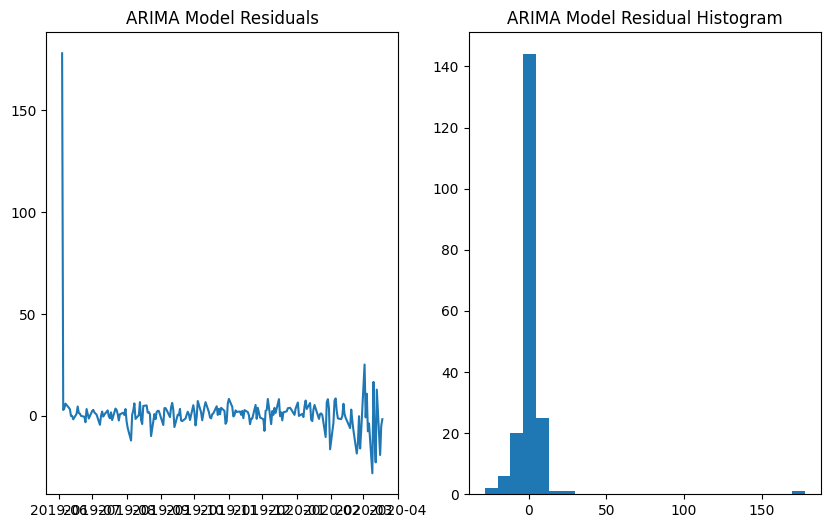

     lb_stat  lb_pvalue
10  0.791517   0.999942


/home/ubuntu/work_space/adp_hands_on/.adp_hands_on/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/ubuntu/work_space/adp_hands_on/.adp_hands_on/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


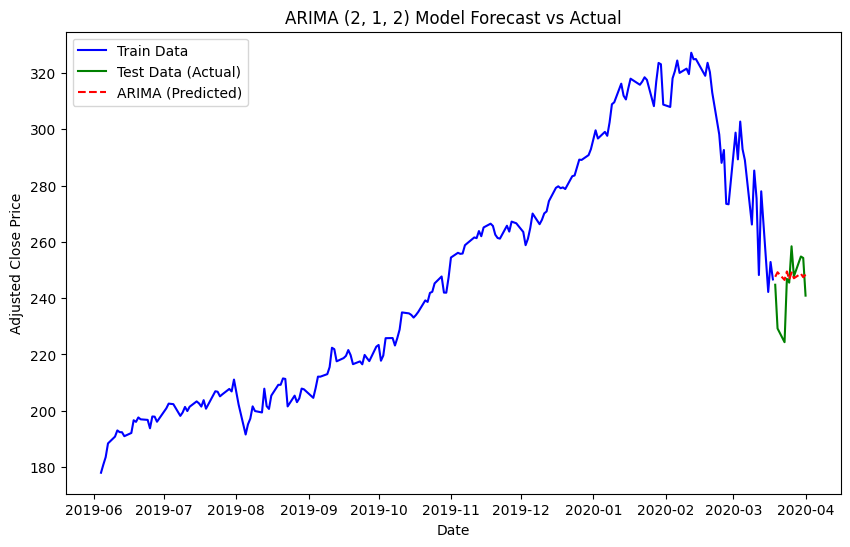

Mean Squared Error (MSE): 113.11157335319872
Root Mean Squared Error (RMSE): 10.635392487031154
Mean Absolute Error (MAE): 7.90452179675915


In [11]:
train_data = aapl_df['Adj Close'][-210:-10]
test_data = aapl_df['Adj Close'][-10:]

model = ARIMA(train_data, order = (2, 1, 2))
arima_model = model.fit()

print(arima_model.summary())

arima_residuals = arima_model.resid
plt.figure(figsize = (10, 6))
plt.subplot(121)
plt.plot(arima_residuals)
plt.title('ARIMA Model Residuals')
plt.subplot(122)
plt.hist(arima_residuals, bins = 25)
plt.title('ARIMA Model Residual Histogram')
plt.show()

ljung_box_arima = acorr_ljungbox(arima_residuals, lags = [10], return_df = True)
print(ljung_box_arima)

forecast = arima_model.forecast(steps = len(test_data))

plt.figure(figsize = (10, 6))
plt.plot(train_data.index, train_data, label = 'Train Data', color = 'blue')
plt.plot(test_data.index, test_data, label = 'Test Data (Actual)', color = 'green')
plt.plot(test_data.index, forecast, label = 'ARIMA (Predicted)', color = 'red', linestyle = '--')
plt.title('ARIMA (2, 1, 2) Model Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, forecast)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  200
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -631.922
Date:                Tue, 06 May 2025   AIC                           1271.845
Time:                        15:46:31   BIC                           1285.018
Sample:                             0   HQIC                          1277.176
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3069      0.038    -34.663      0.000      -1.381      -1.233
ar.L2         -0.4114      0.036    -11.558      0.000      -0.481      -0.342
ma.L1          0.9865      0.016     62.460      0.0

/home/ubuntu/work_space/adp_hands_on/.adp_hands_on/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ubuntu/work_space/adp_hands_on/.adp_hands_on/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ubuntu/work_space/adp_hands_on/.adp_hands_on/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ubuntu/work_space/adp_hands_on/.adp_hands_on/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWar

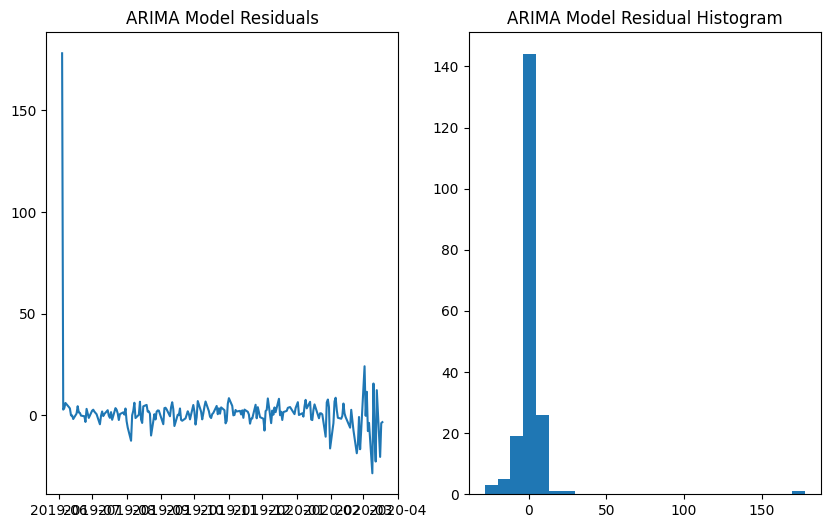

     lb_stat  lb_pvalue
10  0.862923   0.999913


/home/ubuntu/work_space/adp_hands_on/.adp_hands_on/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/ubuntu/work_space/adp_hands_on/.adp_hands_on/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


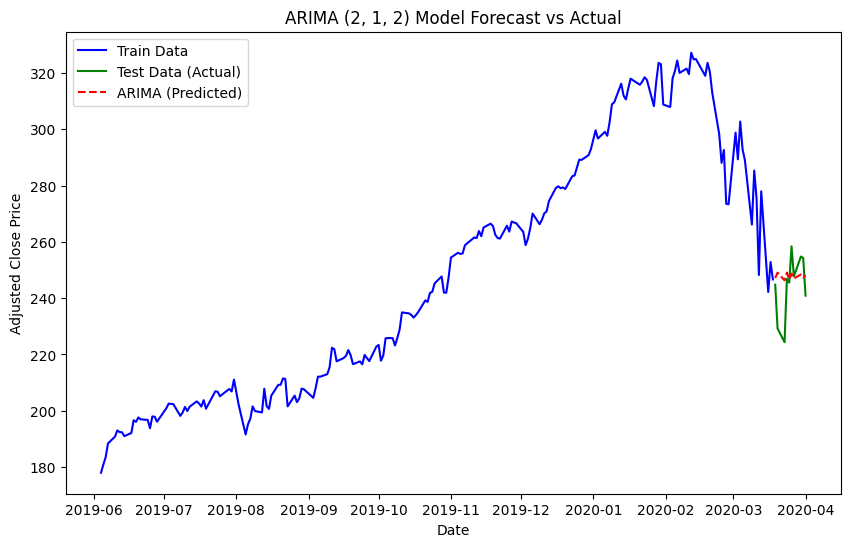

Mean Squared Error (MSE): 112.61435231811429
Root Mean Squared Error (RMSE): 10.61199096862197
Mean Absolute Error (MAE): 7.8637272076551


In [12]:
model = ARIMA(train_data, order = (2, 1, 1))
arima_model = model.fit()

print(arima_model.summary())

arima_residuals = arima_model.resid
plt.figure(figsize = (10, 6))
plt.subplot(121)
plt.plot(arima_residuals)
plt.title('ARIMA Model Residuals')
plt.subplot(122)
plt.hist(arima_residuals, bins = 25)
plt.title('ARIMA Model Residual Histogram')
plt.show()

ljung_box_arima = acorr_ljungbox(arima_residuals, lags = [10], return_df = True)
print(ljung_box_arima)

forecast = arima_model.forecast(steps = len(test_data))

plt.figure(figsize = (10, 6))
plt.plot(train_data.index, train_data, label = 'Train Data', color = 'blue')
plt.plot(test_data.index, test_data, label = 'Test Data (Actual)', color = 'green')
plt.plot(test_data.index, forecast, label = 'ARIMA (Predicted)', color = 'red', linestyle = '--')
plt.title('ARIMA (2, 1, 2) Model Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, forecast)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

코로나 시기와 겹치면서 잔차의 분산이 일정하지 않게 나타남.

In [13]:
aapl_path = '/hdd/data/adp_data/stocks/AAPL.csv'
aapl_df = pd.read_csv(aapl_path, parse_dates=['Date'], index_col='Date')
aapl_df = aapl_df[-210:]

Predicted Daily Volatility (σ):
[7.71822078 7.72521189 7.73219667 7.73917516 7.74614735 7.75311328
 7.76007295 7.76702639 7.77397361 7.78091462]


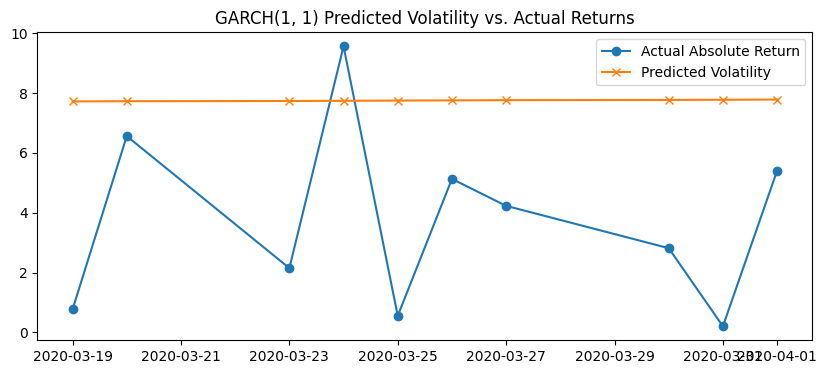

In [14]:
aapl_df['log_return'] = np.log(aapl_df['Adj Close']).diff().dropna()
returns = aapl_df['log_return'].dropna() * 100

train = returns[:-10]
test = returns[-10:]

model = arch_model(train, vol = 'GARCH', p = 1, q = 1, mean = 'Zero', dist = 'normal')
res = model.fit(disp = 'off')

forecast = res.forecast(horizon = 10)
forecast_variance = forecast.variance.values[-1, :]
forecast_volatility = np.sqrt(forecast_variance)

print('Predicted Daily Volatility (σ):')
print(forecast_volatility)

plt.figure(figsize = (10, 4))
plt.plot(test.index, np.abs(test.values), label = 'Actual Absolute Return', marker = 'o')
plt.plot(test.index, forecast_volatility, label = 'Predicted Volatility', marker = 'x')
plt.title('GARCH(1, 1) Predicted Volatility vs. Actual Returns')
plt.legend()
plt.show()

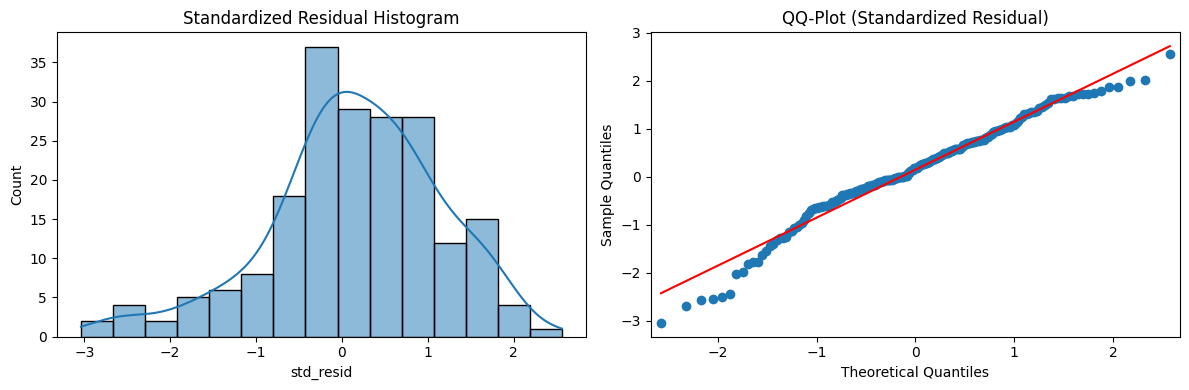

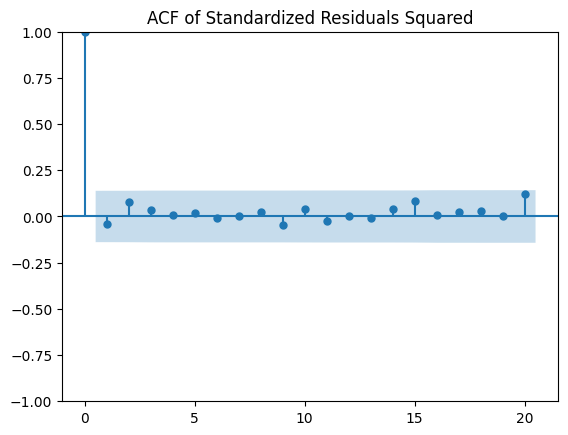

     lb_stat  lb_pvalue
10  2.819715   0.985354


In [15]:
residuals = res.resid
std_resid = res.std_resid

fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.histplot(std_resid, kde = True, ax = axes[0])
axes[0].set_title('Standardized Residual Histogram')

sm.qqplot(std_resid, line = 's', ax = axes[1])
axes[1].set_title('QQ-Plot (Standardized Residual)')

plt.tight_layout()
plt.show()

sm.graphics.tsa.plot_acf(std_resid ** 2, lags = 20)
plt.title('ACF of Standardized Residuals Squared')
plt.show()

ljung_box_garch = acorr_ljungbox(std_resid ** 2, lags = [10], return_df = True)
print(ljung_box_garch)

GARCH, ARIMA 모두 코로나의 영향으로 예측력이 떨어짐.